In [13]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [14]:
#Taking note of the current versions used
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [15]:
#loading the dataset, from the json file stored in the given directory below, and visualising it
import os
main_directory="/content/drive/My Drive/Sarcasm/archive"
data_files=os.listdir(main_directory)
data_directory=main_directory + "/" + data_files[0]
data=pd.read_json(data_directory,lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [16]:
#Removing the link, and putting the organisation in its place
import re
data["organization"]=data["article_link"].apply(lambda x: re.findall(r"\w+",x)[2])
data=data.drop(["article_link"],axis=1)
data.head()

,is_sarcastic,headline,organization
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


In [17]:
#Sample Headline
x=data['headline'][1396]
x

'7 questions about the recent oil price slump'

In [18]:
#Now, before any other preprocessing is done, let it be verified if whether or not the data is balanced
#Checking the nature of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   organization  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [19]:
#Understanding the data, to see if it is skewed or not
data.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


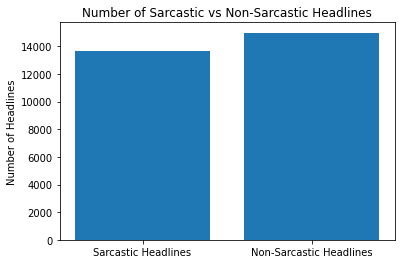

In [20]:
#The above statements can be visualised as
sarcastic=0
for i in range(len(data["is_sarcastic"])):
    if data["is_sarcastic"].iloc[i]==1:
        sarcastic+=1
normal=len(data["is_sarcastic"])-sarcastic
label_values={"Sarcastic Headlines" : sarcastic, "Non-Sarcastic Headlines" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.title("Number of Sarcastic vs Non-Sarcastic Headlines")
plt.ylabel("Number of Headlines")
plt.show()

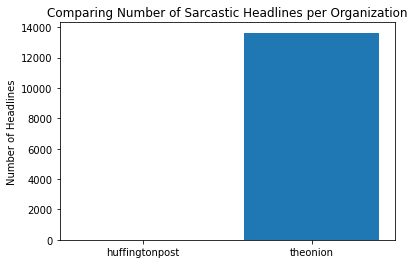

In [21]:
#Now, to ignore the effect of the organization on whether a headline is sarcastic, we need to check for skew
#list(data["organization"].unique()) returns only two organizations 'huffingtonpost' and 'theonion'
org_labels={"huffingtonpost" : 0, "theonion" : 0}
for i in range(len(data["organization"])):
    if data["is_sarcastic"].iloc[i]==1:
        org_labels[data["organization"].iloc[i]]+=1
plt.bar(org_labels.keys(),org_labels.values(),align="center")
plt.title("Comparing Number of Sarcastic Headlines per Organization")
plt.ylabel("Number of Headlines")
plt.show()

In [22]:
#Dropping the "organization" column
data=data.drop(["organization"],axis=1)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Note that the training data/test data split will be done later

num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["headline"]))
X=tokenizer.texts_to_sequences(list(data["headline"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["is_sarcastic"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 30884
The shape of the trainable data : (28619, 300)
The shape of the labels for the data is : (28619, 2)


In [24]:
#Getting the pre trained GloVe embeddings into the embedding matrix from the link used in this cell
embedding_words={}
folder_directory="/content/drive/My Drive/Sarcasm/glove.6B"
file=open(folder_directory + "/" +  "glove.6B.300d.txt",'r', encoding="utf-8")
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


In [25]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [26]:
#Creating the embedding layer further with the help of keras
#These embeddings are made non-trainable as they are pre trained to highly optimized values
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
#Getting the shape of the embedding matrix (should be (num_words,embedding_dim)=(20000,300))
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))

The shape of the embedding matrix is (20000, 300)


In [27]:
#Building the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Flatten())
model.add(Dense(30,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [28]:
#Splittting the data into training and testing sets before fitting the model
#Using a 80% - 20% split for the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [29]:
batch_size=128 #Using a batch size of 128, during gradient descent
num_epochs=10 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))

Epoch 1/10
179/179 [==============================] - 17s 45ms/step - loss: 0.6069 - accuracy: 0.6509 - val_loss: 0.4200 - val_accuracy: 0.8103
Epoch 2/10
179/179 [==============================] - 7s 41ms/step - loss: 0.4438 - accuracy: 0.8008 - val_loss: 0.3713 - val_accuracy: 0.8351
Epoch 3/10
179/179 [==============================] - 7s 41ms/step - loss: 0.3900 - accuracy: 0.8318 - val_loss: 0.3586 - val_accuracy: 0.8477
Epoch 4/10
179/179 [==============================] - 7s 41ms/step - loss: 0.3615 - accuracy: 0.8447 - val_loss: 0.3401 - val_accuracy: 0.8505
Epoch 5/10
179/179 [==============================] - 7s 41ms/step - loss: 0.3462 - accuracy: 0.8479 - val_loss: 0.3376 - val_accuracy: 0.8510
Epoch 6/10
179/179 [==============================] - 7s 41ms/step - loss: 0.3290 - accuracy: 0.8588 - val_loss: 0.3328 - val_accuracy: 0.8531
Epoch 7/10
179/179 [==============================] - 7s 41ms/step - loss: 0.3183 - accuracy: 0.8638 - val_loss: 0.3350 - val_accuracy: 0.856

In [30]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))

179/179 [==============================] - 2s 10ms/step - loss: 0.3216 - accuracy: 0.8601
The loss of the model on the test set : 0.3216022253036499
The accuracy of the model on the test set : 86.00628972053528%


In [31]:
#Visualising the summary of the network used
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 149, 256)          164864    
_________________________________________________________________
flatten (Flatten)            (None, 38144)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1

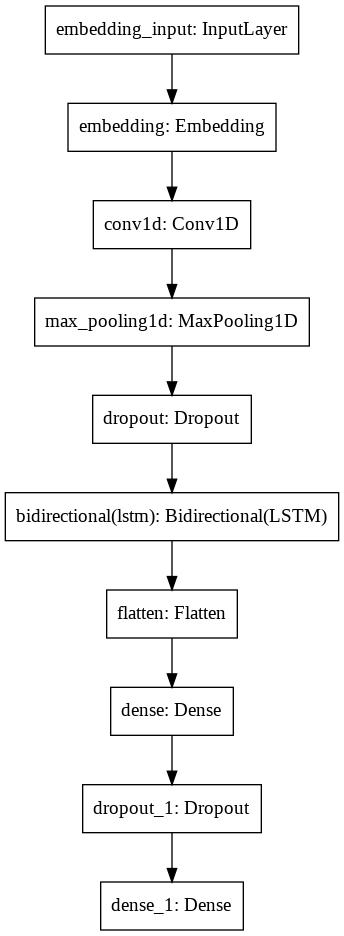

In [32]:
#Visualising the network architecture of the model
from keras.utils import plot_model
plot_model(model,to_file="bidir_lstm.jpg")

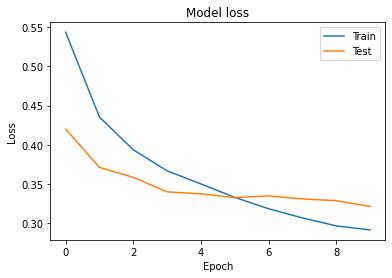

In [33]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

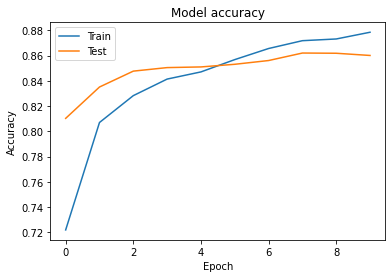

In [34]:
#Visualising the accuracy of the model, throughout the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("modelacc_sarcasmdetection.jpg")

In [35]:
metric_examples_dir=main_directory + "/" + data_files[1]
metric_examples=pd.read_json(metric_examples_dir,lines=True)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [36]:
metric_examples["organization"]=metric_examples["article_link"].apply(lambda x: re.findall(r"\w+",x)[2])
metric_examples=metric_examples.drop(["article_link"],axis=1)
metric_examples.head()

,headline,is_sarcastic,organization
0,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,mom starting to fear son's web series closest ...,1,theonion
3,"boehner just wants wife to listen, not come up...",1,theonion
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [37]:
metric_examples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
 2   organization  26709 non-null  object
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [38]:
#Initializing all the metrics for evaluation
true_positive = 0 
true_negative = 0 
false_positive = 0 
false_negative = 0

In [39]:
my_headline1="report: 70% of trump endorsements made after staring at bedroom ceiling for 4 hours" # Meant to be sarcastic
my_headline2="7 questions about the recent oil price slump" # Meant to be non-sarcastic

my_headline11=tokenizer.texts_to_sequences(my_headline1)
my_headline22=tokenizer.texts_to_sequences(my_headline2)

my_headline11=pad_sequences(my_headline11,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline22=pad_sequences(my_headline22,maxlen=max_sentence_len,dtype="int32",value=0)

prediction1=model.predict(my_headline11,batch_size=1)[0]
prediction2=model.predict(my_headline22,batch_size=1)[0]

if np.argmax(prediction1)==1:
    print("The headline - " + my_headline1 + " : Sarcastic")
else:
    print("The headline - " + my_headline1 + " : Not Sarcastic")
    
if np.argmax(prediction2)==1:
    print("The headline - " + my_headline2 + " : Sarcastic")
else:
    print("The headline - " + my_headline2 + " : Not Sarcastic")

The headline - report: 70% of trump endorsements made after staring at bedroom ceiling for 4 hours : Sarcastic
The headline - 7 questions about the recent oil price slump : Not Sarcastic


In [40]:
#Checking the performance of the model
for i in range(y_test.shape[0]):
  x = x_test[i].reshape(1,300)
  prediction = model.predict(x,batch_size=1)[0]
  if(np.argmax(prediction)==np.argmax(y_test[i]) and np.argmax(prediction)==1) :
    true_positive+=1 
  elif(np.argmax(prediction)==np.argmax(y_test[i]) and np.argmax(prediction)==0) :
    true_negative+=1
  elif(np.argmax(prediction)!=np.argmax(y_test[i]) and np.argmax(prediction)==1) :
    false_positive+=1 
  else :
    false_negative+=1
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
f1score = (2*precision*recall)/(precision+recall)
print("True Positives : {}, True Negatives : {}, False Positives : {}, False Negatives : {}".format(true_positive,true_negative,false_positive,false_negative))
print("Precision : {}, Recall : {}, F1 Score : {}".format(precision,recall,f1score))

True Positives : 2330, True Negatives : 2593, False Positives : 403, False Negatives : 398
Precision : 0.8525429930479327, Recall : 0.8541055718475073, F1 Score : 0.8533235671122505
